In [1]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy.integrate as integrate
import matplotlib.pyplot as plt


2024-05-07 21:26:22.033953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 21:26:22.033990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 21:26:22.035520: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-07 21:26:22.042755: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 21:26:22.811205: W tensorflow/compiler/tf2

In [2]:
# Load the base VGG16 model, pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False)

# Freeze all layers except last four layers 
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)


2024-05-07 21:26:24.611058: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-07 21:26:24.653915: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-07 21:26:24.654393: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)



In [4]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])



In [5]:
# Create data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        'cleaned_images',
        target_size=(299, 299),
        batch_size=32,
        class_mode='binary')


Found 3194 images belonging to 1 classes.


In [6]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples//train_generator.batch_size,  callbacks=[callback],
      epochs=100)


Epoch 1/100


2024-05-07 21:26:50.469473: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-07 21:26:59.848379: I external/local_xla/xla/service/service.cc:168] XLA service 0x7273a4707e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-07 21:26:59.848409: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-05-07 21:26:59.854068: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715097419.936771   31854 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


99/99 [==============================] - 61s 492ms/step - loss: 0.0863 - accuracy: 0.9851
Epoch 2/100
99/99 [==============================] - 43s 433ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 3/100
99/99 [==============================] - 43s 436ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 4/100
99/99 [==============================] - 43s 436ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 5/100
99/99 [==============================] - 43s 432ms/step - loss: 9.8560e-04 - accuracy: 1.0000
Epoch 6/100
99/99 [==============================] - 42s 424ms/step - loss: 6.3943e-04 - accuracy: 1.0000
Epoch 7/100
99/99 [==============================] - 43s 436ms/step - loss: 4.8316e-04 - accuracy: 1.0000
Epoch 8/100
99/99 [==============================] - 43s 429ms/step - loss: 3.3665e-04 - accuracy: 1.0000
Epoch 9/100
99/99 [==============================] - 43s 436ms/step - loss: 2.7853e-04 - accuracy: 1.0000
Epoch 10/100
99/99 [==============================] - 42s 427ms/step - los

In [7]:
model.save("InceptionV3-Run2.Keras")

INFO:tensorflow:Assets written to: InceptionV3-Run2.Keras/assets


INFO:tensorflow:Assets written to: InceptionV3-Run2.Keras/assets


In [8]:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learing_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples//train_generator.batch_size,  callbacks=[callback],
      epochs=100)

Epoch 1/100
35/99 [=========>....................] - ETA: 29s - loss: 3.8193e-07 - accuracy: 1.0000

KeyboardInterrupt: 

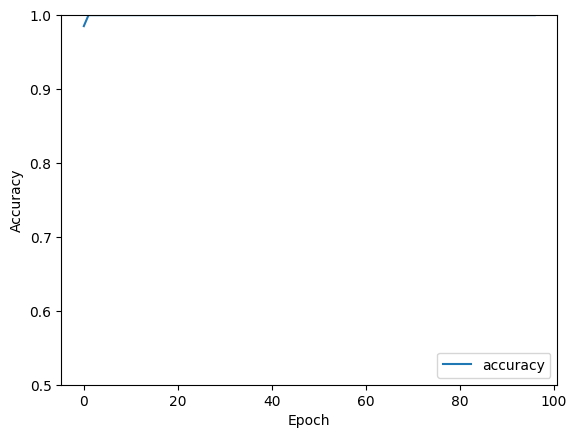

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

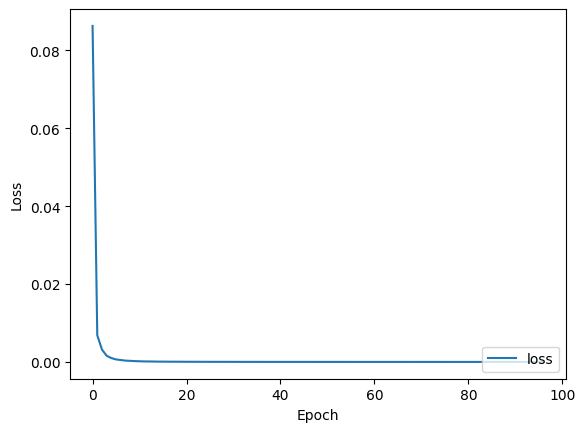

In [8]:
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')